In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 28023147.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-2])
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
      return self.feature_extractor(x)

    def forward(self, x):
        feature = self.get_features(x)
        return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))

In [5]:
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 272MB/s]


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

In [7]:
model.train()
for epoch in range(num_epochs):
  #### To Do (4 pts) #####
  # Fine-tune model on CIFAR-10 dataset
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
  ################

<ipython-input-4-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


In [14]:
def poisoning_example_generation(t, b, f, lmda=0.1, max_iters=10, beta=1):
    """
    t: target instance
    b: base instance
    f: feature extractor
    lambda: learning rate
    """
    #### To Do (9 pts) #####
    # Create poisoned sample by following the algorithm you've learned in the class
    xi = b.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        features = f(xi)
        loss = torch.norm(features - f(t)) ** 2
        grad = torch.autograd.grad(loss, xi)[0]
        xbi = xi - lmda * grad
        xi = (xbi + lmda * beta * b) / (1 + lmda * beta)

    return xi
  ################



In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


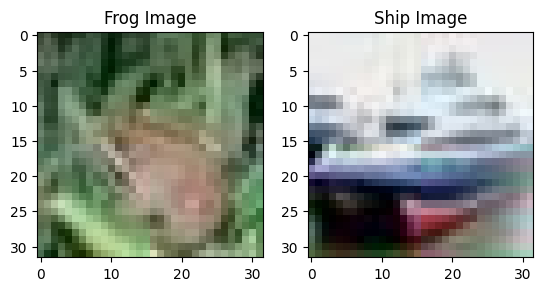

Predicted label for the frog image: deer
Predicted label for the ship image: ship
Logit for the predicted class of the frog image: 0.99999976
Logit for the predicted class of the ship image: 0.9999995


<ipython-input-4-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


In [10]:
#### To Do (2 pts) #####
# Show the frog and ship images
# Evaluate model on them (compute predicted label)
# Show the frog and ship images
frog_image_path = '/content/drive/MyDrive/MSC1401_1/SPML/HW6/frog.jpeg'
ship_image_path = '/content/drive/MyDrive/MSC1401_1/SPML/HW6/ship.jpeg'


frog_image = Image.open(frog_image_path)
ship_image = Image.open(ship_image_path)

plt.subplot(1, 2, 1)
plt.imshow(frog_image)
plt.title('Frog Image')

plt.subplot(1, 2, 2)
plt.imshow(ship_image)
plt.title('Ship Image')

plt.show()

model.eval()

frog_tensor = transform(frog_image).unsqueeze(0).to(device)
ship_tensor = transform(ship_image).unsqueeze(0).to(device)


with torch.no_grad():
    frog_output = model(frog_tensor)
    ship_output = model(ship_tensor)

frog_logits = frog_output.squeeze().cpu().numpy()
ship_logits = ship_output.squeeze().cpu().numpy()

_, frog_predicted = torch.max(frog_output.data, 1)
_, ship_predicted = torch.max(ship_output.data, 1)

frog_label = classes[frog_predicted.item()]
ship_label = classes[ship_predicted.item()]

print('Predicted label for the frog image:', frog_label)
print('Predicted label for the ship image:', ship_label)

frog_logit = frog_logits[frog_predicted.item()]
ship_logit = ship_logits[ship_predicted.item()]

print('Logit for the predicted class of the frog image:', frog_logit)
print('Logit for the predicted class of the ship image:', ship_logit)


################

<ipython-input-4-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


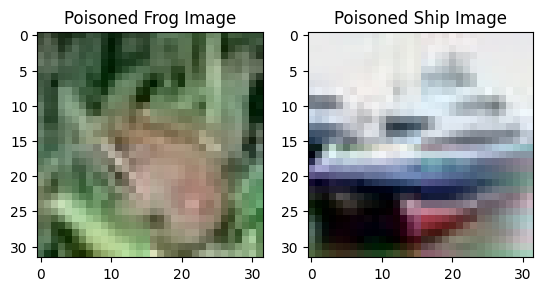

Predicted label for the poisoned frog image: deer
Predicted label for the poisoned ship image: ship
Logit for the predicted class of the poisoned frog image: 0.99999976
Logit for the predicted class of the poisoned ship image: 0.9999995


In [15]:
#### To Do (2 pts) #####
# Create poisoned samples
# Evaluate model on them (compute predicted label)

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform_normalize_inv = torchvision.transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)

poisoned_ship = poisoning_example_generation(frog_tensor, ship_tensor, model, lmda=0.1, max_iters=10, beta=1)
poisoned_frog = poisoning_example_generation(ship_tensor, frog_tensor, model, lmda=0.1, max_iters=10, beta=1)

poisoned_frog_image = transforms.ToPILImage()(transform_normalize_inv(poisoned_frog).squeeze().cpu())
poisoned_ship_image = transforms.ToPILImage()(transform_normalize_inv(poisoned_ship).squeeze().cpu())

plt.subplot(1, 2, 1)
plt.imshow(poisoned_frog_image)
plt.title('Poisoned Frog Image')

plt.subplot(1, 2, 2)
plt.imshow(poisoned_ship_image)
plt.title('Poisoned Ship Image')

plt.show()

with torch.no_grad():
    poisoned_frog_output = model(poisoned_frog.to(device))
    poisoned_ship_output = model(poisoned_ship.to(device))

poisoned_frog_logits = poisoned_frog_output.squeeze().cpu().numpy()
poisoned_ship_logits = poisoned_ship_output.squeeze().cpu().numpy()

_, poisoned_frog_predicted = torch.max(poisoned_frog_output.data, 1)
_, poisoned_ship_predicted = torch.max(poisoned_ship_output.data, 1)

poisoned_frog_label = classes[poisoned_frog_predicted.item()]
poisoned_ship_label = classes[poisoned_ship_predicted.item()]

print('Predicted label for the poisoned frog image:', poisoned_frog_label)
print('Predicted label for the poisoned ship image:', poisoned_ship_label)

poisoned_frog_logit = poisoned_frog_logits[poisoned_frog_predicted.item()]
poisoned_ship_logit = poisoned_ship_logits[poisoned_ship_predicted.item()]

print('Logit for the predicted class of the poisoned frog image:', poisoned_frog_logit)
print('Logit for the predicted class of the poisoned ship image:', poisoned_ship_logit)


################